### 问题四 基于数据驱动的磁芯损耗预测模型
#### 在磁芯损耗的研究领域中，尽管存在着众多传统模型（如文首“背景”所述），这些模型各自在不同的条件下展现了一定的应用价值，但普遍面临精度不足或适用范围受限的挑战。当前，业界缺乏一个既广泛适用又能提供高精度预测结果的磁芯损耗模型，这直接制约了磁性元件设计中对损耗的精确评估，进而影响了整体功率变换器效率的有效预估。鉴于这一现状，业界对构建更为便捷、精准的数据驱动模型寄予了厚望，旨在开发出一个能够跨越不同材料类型与工况条件的磁芯损耗预测模型。这样的模型将极大提升磁性元件设计的精确性与效率，为电力电子技术的进一步发展奠定坚实基础。
#### 请利用附件一中的实验数据，通过数据分析与建模技术，构建磁芯损耗预测模型，分析模型的预测精度、泛化能力，以及对业界的各种指导意义；同时对附件三中样本的磁芯损耗进行预测，把预测结果填入附件四（Excel表格）中第3列，要求：（1）按样本序号填入相应的磁芯损耗预测结果，只保留小数点后1位；（2）结果填入附件四后，保留原文件名，（与问题一的结果一起）以附件材料上传；（3）特别把附件三中样本序号为：16、76、98、126、168、230、271、338、348、379的磁芯损耗预测结果，以表格形式呈现在论文正文中。

#### 对于这一问题，我们可以建立一个集成模型，基于修正的斯坦麦茨方程和磁芯损耗分离模型集成输出磁芯损耗

In [1]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import pearsonr
# 忽略所有的警告
warnings.filterwarnings("ignore")

# 设置字体为 SimHei（黑体）以支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 解决负号


In [2]:
import pandas as pd

file_path = '../附件一（训练集）.xlsx'  

# 定义 sheet 名字列表，分别为 材料1, 材料2, 材料3, 材料4
sheets = ['材料1', '材料2', '材料3', '材料4']

# 初始化一个空的 DataFrame 来存储所有材料的数据
all_data = pd.DataFrame()

# 读取每个 sheet 的前四列，并添加材料列
for sheet in sheets:
    # 读取 sheet 前四列
    data = pd.read_excel(file_path, sheet_name=sheet)
    
    # 添加一列材料信息
    data['磁芯材料'] = sheet
    
    # 将当前 sheet 的数据添加到总的 DataFrame 中
    all_data = pd.concat([all_data, data], ignore_index=True)
all_data


,温度，oC,频率，Hz,磁芯损耗，w/m3,励磁波形,0（磁通密度B，T）,1,2,3,4,5,...,1016,1017,1018,1019,1020,1021,1022,1023,磁芯材料,0（磁通密度，T）
0,25,50030,1997.955250,正弦波,0.000213,0.000389,0.000566,0.000743,0.000919,0.001096,...,-0.001198,-0.001022,-0.000846,-0.000669,-0.000492,-0.000316,-0.000140,0.000036,材料1,NaN
1,25,50020,2427.749830,正弦波,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,...,-0.002091,-0.001899,-0.001707,-0.001515,-0.001322,-0.001129,-0.000937,-0.000744,材料1,NaN
2,25,50020,3332.725760,正弦波,-0.003780,-0.003564,-0.003349,-0.003134,-0.002919,-0.002704,...,-0.005499,-0.005285,-0.005070,-0.004855,-0.004640,-0.004425,-0.004210,-0.003995,材料1,NaN
3,25,50020,4502.908007,正弦波,-0.000511,-0.000267,-0.000023,0.000222,0.000466,0.000711,...,-0.002463,-0.002220,-0.001976,-0.001732,-0.001488,-0.001244,-0.001000,-0.000756,材料1,NaN
4,25,50030,6063.023248,正弦波,0.000458,0.000732,0.001007,0.001281,0.001555,0.001830,...,-0.001741,-0.001466,-0.001192,-0.000917,-0.000642,-0.000367,-0.000092,0.000183,材料1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12395,90,199190,20604.900210,梯形波,-0.017758,-0.017339,-0.016932,-0.016534,-0.016140,-0.015745,...,-0.019854,-0.019692,-0.019528,-0.019356,-0.019157,-0.018903,-0.018573,-0.018180,材料4,NaN
12396,90,199190,26504.284280,梯形波,-0.019690,-0.019227,-0.018776,-0.018334,-0.017895,-0.017456,...,-0.022062,-0.021886,-0.021706,-0.021513,-0.021285,-0.020987,-0.020605,-0.020159,材料4,NaN
12397,90,199190,46232.491530,梯形波,-0.024998,-0.024411,-0.023838,-0.023278,-0.022722,-0.022165,...,-0.027966,-0.027739,-0.027509,-0.027266,-0.026981,-0.026614,-0.026142,-0.025587,材料4,NaN
12398,90,199190,61458.085900,梯形波,-0.027988,-0.027329,-0.026687,-0.026060,-0.025438,-0.024816,...,-0.031314,-0.031056,-0.030793,-0.030516,-0.030196,-0.029787,-0.029264,-0.028647,材料4,NaN


#### 修正的斯坦麦茨方程$P=a1•f^{a2}•B_m^{a3}•log(T)^{a4}$

#### 损耗分离模型$P_{core}=P_{h}+P_{cl}+P_{e} .$
* $P_h=b1•f•B_m^{b2} $
* $P_{cl}=b3•f^2•B_m^2$
* $P_e=8•\sqrt{\sigma\cdot S\cdot G\cdot V_0}•f^{1.5}•B_m^{1.5}$
#### 其中除了$\sigma$和$S$分别表示电导率和磁性元件的有效截面积之外，其他参数都是待优化的参数

#### 我们在问题2中，已经获得了修正的斯坦麦茨方程的相关参数值，现在，我们对磁芯损耗分离模型的参数进行拟合，而由于数据中不存在电导率和有效截面积，我们将其同样作为参数进行优化$b4 = \sigma\cdot S\cdot V_0$，在优化时，我们需要考虑不同材料和不同励磁波形，分别做参数进行拟合

#### 同样的，我们为损耗分离模型加上温度项

#### 首先，我们利用L-BFGS-B优化算法来基于不同的数据确定合适的k、α，β，得到斯坦麦茨方程的拟合情况以及目标函数值

In [3]:
col = data.columns[4:-1]

# 假设我们有一些已测量的数据
f_data = data['频率，Hz'].values
Bm_data = data[col].max(axis=1).values
P_data = data['磁芯损耗，w/m3'].values
T_data = data['温度，oC'].values

In [4]:
import numpy as np
from scipy.optimize import minimize
 

# 改进的方程
def separate(params, f, Bm):
    a1,a2,a3,a4 = params
    return a1*f*Bm**a2+a3*f**2*Bm**2+8*(a4*0.1356)**0.5*f**1.5*Bm**1.5

# 定义目标函数：平方误差
def objective_sep(params, f, Bm, P):
    P_pred = separate(params, f, Bm)
    return np.sum((P_pred - P)**2)


def steinmetz_eq_adjust(params, f, Bm, T):
    k1, alpha1, beta1, gamma1 = params
    return k1 * f**alpha1 * Bm**beta1 * np.log(T)**gamma1

# 定义目标函数：平方误差
def objective_adjust(params, f, Bm, P, T):
    P_pred = steinmetz_eq_adjust(params, f, Bm, T)
    return np.sum((P_pred - P)**2)

ls = []
bo = []
mat = []
af = []
bf = []
for i in all_data['磁芯材料'].unique():
    for o in all_data['励磁波形'].unique():
        tem = all_data[(all_data.磁芯材料==i)&(all_data.励磁波形==o)]
        
        f_data = tem['频率，Hz'].values
        Bm_data = tem[col].max(axis=1).values
        P_data = tem['磁芯损耗，w/m3'].values
        T_data = tem['温度，oC'].values

        #损耗分离模型
        initial_guess = [0,0,0,0]
        bounds = [(0, None), (1, 3), (0, None),(0,None)]  # k1 > 0, 1 < alpha1 < 3, 2 < beta1 < 3
        result = minimize(objective_sep, initial_guess, args=(f_data, Bm_data, P_data), bounds=bounds, method='L-BFGS-B')
        b1, b2, b3, b4 = result.x
        a_func = result.fun
        #改进的斯坦麦茨方程 
        initial_guess = [0,0,0,1]
        bounds = [(0, None), (1, 3), (2, 3),(None,None)]  # k1 > 0, 1 < alpha1 < 3, 2 < beta1 < 3
        result = minimize(objective_adjust, initial_guess, args=(f_data, Bm_data, P_data,T_data), bounds=bounds, method='L-BFGS-B')
        a1,a2,a3,a4 = result.x
        b_func = result.fun
        
        ls.append([a1,a2,a3,a4,b1,b2,b3,b4])
        bo.append(o)
        mat.append(i)
        af.append(a_func)
        bf.append(b_func)
result = pd.DataFrame(ls,columns=['a1','a2','a3','a4','b1','b2','b3','b4'])
result['励磁波形'] = bo
result['材料'] = mat
result['损耗分离模型'] = af
result['修正斯坦麦茨方程损失'] = bf


### 总损耗=$\alpha  修正斯坦麦茨方程+\beta 损耗分离模型$

In [5]:
def ensemble(params, a1,a2,a3,a4,b1,b2,b3,b4,f, Bm, T):
    a,b = params
    return a*steinmetz_eq_adjust([a1,a2,a3,a4], f, Bm, T) + b*separate([b1,b2,b3,b4], f, Bm)

# 定义目标函数：平方误差
def objectivet(params, a1,a2,a3,a4,b1,b2,b3,b4,f, Bm, P, T):
    P_pred = ensemble(params, a1,a2,a3,a4,b1,b2,b3,b4,f, Bm, T)
    return np.sum((P_pred - P)**2)

als = []
bls = []
total_cost = []
for i in all_data['磁芯材料'].unique():
    for o in all_data['励磁波形'].unique():
        tem = all_data[(all_data.磁芯材料==i)&(all_data.励磁波形==o)]
        a1,a2,a3,a4,b1,b2,b3,b4 = result[(result.材料==i)&(result.励磁波形==o)][['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4']].values[0]
        
        f_data = tem['频率，Hz'].values
        Bm_data = tem[col].max(axis=1).values
        P_data = tem['磁芯损耗，w/m3'].values
        T_data = tem['温度，oC'].values
        
        
        #损耗分离模型
        initial_guess = [0.5,0.5]
        bounds = [(0, 1), (0, 1)]  # k1 > 0, 1 < alpha1 < 3, 2 < beta1 < 3
        total_result = minimize(objectivet, initial_guess, args=(a1,a2,a3,a4,b1,b2,b3,b4,f_data, Bm_data, P_data,T_data), bounds=bounds, method='L-BFGS-B')
        a,b = total_result.x
        func = total_result.fun
            
        als.append(a)
        bls.append(b)
        total_cost.append(func)
        
result['a'] = als
result['b'] = bls
result['cost'] = total_cost
result.to_excel('./不同材料不同波形的损耗分离模型和修正方程模型拟合结果.xlsx',index=False)
result

,a1,a2,a3,a4,b1,b2,b3,b4,励磁波形,材料,损耗分离模型,修正斯坦麦茨方程损失,a,b,cost
0,7.368265,1.466915,2.451521,-1.510662,0.000000e+00,1.0,0.000716,3.616264e-08,正弦波,材料1,6.777555e+12,1.447990e+11,0.989870,0.012022,1.439728e+11
1,21.558222,1.268477,2.000000,-0.956602,9.714446e-07,1.0,0.000047,1.504900e-03,三角波,材料1,2.372132e+13,9.638618e+12,0.886876,0.119129,9.391422e+12
2,1.279650,1.571948,2.365214,-1.235325,0.000000e+00,1.0,0.000722,1.059254e-07,梯形波,材料1,9.528959e+12,2.583470e+11,0.988585,0.012312,2.570124e+11
3,5.992775,1.489006,2.347763,-1.504196,0.000000e+00,1.0,0.000772,3.506102e-07,正弦波,材料2,6.540775e+12,2.336712e+11,0.976362,0.029161,2.290826e+11
4,3.729907,1.427762,2.045040,-0.986508,0.000000e+00,1.0,0.000240,1.055987e-03,三角波,材料2,3.862614e+13,8.879885e+12,0.972753,0.029820,8.854254e+12
5,1.061344,1.560109,2.258313,-0.960732,0.000000e+00,1.0,0.000622,1.077684e-04,梯形波,材料2,2.835746e+13,1.460342e+12,0.975413,0.027418,1.441215e+12
6,8.169733,1.450616,2.363487,-1.257369,0.000000e+00,1.0,0.000885,0.000000e+00,正弦波,材料3,9.048098e+12,2.825606e+11,0.975241,0.032249,2.751386e+11
7,7.370304,1.379933,2.128236,-0.866283,0.000000e+00,1.0,0.000218,1.457908e-03,三角波,材料3,5.211616e+13,9.251303e+12,0.972535,0.030808,9.212791e+12
8,3.702659,1.462162,2.279015,-0.884179,0.000000e+00,1.0,0.000675,2.440311e-04,梯形波,材料3,6.240959e+13,1.943241e+12,0.980420,0.022612,1.915290e+12
9,12.744099,1.488247,2.486573,-1.674659,0.000000e+00,1.0,0.000738,0.000000e+00,正弦波,材料4,9.800750e+11,4.424592e+10,0.960501,0.048447,4.228244e+10


#### 预测结果

In [6]:
df = pd.read_excel('../附件三（测试集）.xlsx')

f_data = df['频率，Hz'].values
Bm_data = df[col].max(axis=1).values
T_data = df['温度，oC'].values

bo = df['励磁波形'].values
mat = df['磁芯材料'].values

pred_ls = []
for b,m,f,bm,t in zip(bo,mat,f_data,Bm_data,T_data):
    a1,a2,a3,a4,b1,b2,b3,b4,a,b = result[(result.材料==m)&(result.励磁波形==b)][['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4','a1','a2']].values[0]
    pred = ensemble([a,b], a1,a2,a3,a4,b1,b2,b3,b4,f, bm, t)
    pred_ls.append(pred)
pred_ls

[109447.88469277785,
 184285.59936050704,
 291125.71389182174,
 260530.6483879999,
 457439.6636065064,
 137817.87163901117,
 27446.993917358406,
 20498.874764437143,
 3573328.728237546,
 90946.76653921876,
 147786.44044951137,
 1419606.9691188412,
 48856.97660831721,
 34025.27103051631,
 269332.84461895505,
 14957.077242191765,
 1043452.6715769036,
 2386973.073860969,
 22423.671857421676,
 4388499.772881121,
 17585.484600054595,
 422511.08528318745,
 2499416.3931425735,
 115799.4937569139,
 265463.6726208982,
 240148.98640092992,
 1290677.7466399614,
 2760859.7368292836,
 39821.12725643968,
 4728421.104598977,
 78262.93672519011,
 33295.18058482226,
 268924.7671095897,
 455814.318610094,
 35564.48060211436,
 49960.900751227746,
 1319079.9865379403,
 3141640.457809935,
 3960658.068400995,
 8850021.402179707,
 2518238.5218832823,
 20830820.2270799,
 14340482.19553864,
 15121582.47743616,
 95999.8794255042,
 825697.0969034361,
 500599.0791860468,
 8746114.072045129,
 623729.4018593084,
 2

#### 填写结果

In [7]:
r = pd.read_excel('../附件四（Excel表）.xlsx')
r['./附件三（400个样品）磁芯损耗预测结果'] = pred_ls
r.to_excel('./填写结果.xlsx',index=False)


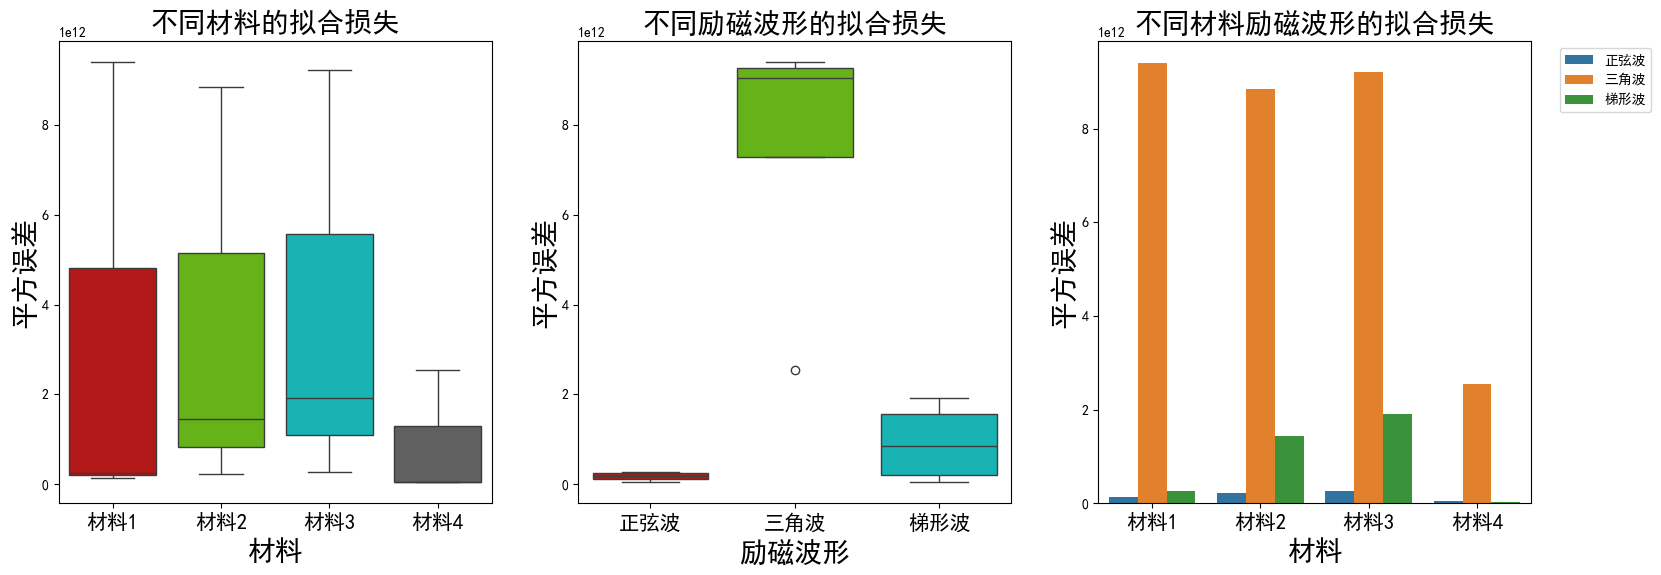

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#CC0000', '#66CC00', '#00CCCC', '#606060']
# 设置不同材料类型的箱型图颜色
palette = {'材料1': colors[0], '材料2': colors[1], '材料3': colors[2],'材料4': colors[3]}

# 3. 不同材料类型下目标函数的箱线图
plt.figure(figsize=(19, 6))
plt.subplot(1, 3, 1)  # 1行3列子图中的第1个
sns.boxplot(data=result, x='材料', y='cost', palette=palette)
plt.title('不同材料的拟合损失',fontsize=20)
plt.xlabel('材料',fontsize=20)
plt.ylabel('平方误差',fontsize=20)
plt.xticks(rotation=0,fontsize=15)

# 设置不同材料类型的箱型图颜色
palette = {'正弦波': colors[0], '三角波': colors[1], '梯形波': colors[2]}
# 4. 不同励磁波形下目标函数的箱线图
plt.subplot(1, 3, 2)  # 1行3列子图中的第2个
sns.boxplot(data=result, x='励磁波形', y='cost', palette=palette)
plt.title('不同励磁波形的拟合损失',fontsize=20)
plt.xlabel('励磁波形',fontsize=20)
plt.ylabel('平方误差',fontsize=20)
plt.xticks(rotation=0,fontsize=15)

# 设置不同材料类型的箱型图颜色
palette = {'材料1': colors[0], '材料2': colors[1], '材料3': colors[2],'材料4': colors[3]}
# 创建分组柱状图，显示材料类型和励磁波形下的目标函数均值
plt.subplot(1, 3, 3)  # 1行3列子图中的第3个
sns.barplot(data=result, x='材料', y='cost', hue='励磁波形')
plt.title('不同材料励磁波形的拟合损失',fontsize=20)
plt.xlabel('材料',fontsize=20)
plt.ylabel('平方误差',fontsize=20)
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0,fontsize=15)
plt.savefig(f'./不同材料与励磁波形的拟合损失.png',dpi=500)
plt.show()
